In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister 
from qiskit import IBMQ, Aer, transpile, assemble 
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.result import marginal_counts
from qiskit.quantum_info import Statevector
import numpy as np
import sympy as sp
sp.init_printing()

def print_bracket(sv):
    '''sv ---> a|0> + b|1> '''
    d = sv.to_dict()

    ket=0
    for i in d.keys():
        temp = sp.symbols('\left|'+i+'\\right>')
        ket += np.round(d[i],3)*temp

    display(ket)

# Kvantumos teleportáció

$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\braket}[2]{\langle #1|#2\rangle} $$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\braket}[2]{\langle #1|#2\rangle} $

A következő jupyter notebook a kvantumos teleportáció jelenségét muatatja be feladatok által, főként a Qiskit tankönyv és a QBronze tananyag ide vonatkozó részét követve. A feladatok egyike sem kifejezetten nehéz, leginkább a jelenség mélyebb megértését igyekeznek elősegíteni.  Minden feladat után további segítségek vannak a megoldásához, a tapasztaltabbak számára a feladatok ezek nélkül is megoldhatóak.

## 1. Bevezetés

A kvantumos teleportáció egy módzser, mely lehetővé teszi a kvantuminformáció továbbítását a kvantum-összefonódás révén. A kommunikáló felek legyenek, a szokásos módon, Alice és Bob. Tegyük fel, hogy Alice szeretne kvantuminformációt küldeni Bobnak. Azaz szeretné a  $\vert\psi\rangle = \alpha\vert0\rangle + \beta\vert1\rangle$ ( itt $\alpha$ és $\beta$ az állapothoz tartozó valószínűségi amplitúdók) kvantumállapotot elküledeni. Ha Alice rendelkezne elegendően sok $\vert\psi\rangle$ állapotú qubittel (kvantum bittel), akkor ezeket megmérve kapna egy, a kvantumállapotot közelítőleg leíró, statisztikát amit már klasszikus bitek formájában továbbíthat Bob számára.

Azonban a kvantummechanikában ismert egy tétel (No-cloning Theorem), mely kimondja, hogy nem lehet kvantumállapotokat tökéletesen lemásolni, ez rámutat az azonos (és tetszőleges) állapotú qubitek generálásának nehézségeire is.

A kvantum teleportáció protokoll erre a problémára kínál egy megoldást, klasszikus kommunikáció és egy összefont qubit pár segítségével. A folyamat végén Bob rendelkezni fog egy $\vert\psi\rangle$ állapotú qubittel, azonban Alice már nem, ezért nevezhetjük teleportációnak a folyamatot.

## 2. A kvantum teleportáció protokoll 

Mint említettük a qubit továbbítására egy összefonódott qubit párt használunk, azaz Alicenak és Bobnak szüksége lesz egy harmadik félre (Telamon), aki létrehozza ezt a qubit párt és egyet-egyet elküld nekik. A protokoll során Alice végrehajt bizonyos műveleteket a qubitjain (az elküldeni kívánt állapotban lévő qubiten és az összefonódott pár nála lévő felén) és megméri, az eredményt klasszikus bitek formájában továbbítja Bob-nak, aki majd ez alapján műveleteket hajt végre a saját qubitján, hogy megkapja az eredeti állapotot. A protokoll során csak lokális műveleteket és klasszikus kommunikációt hajtanak végre, mégis képesek továbbítani egy qubit  kvantumállapotát.

<center> <img src="https://qiskit.org/textbook/ch-algorithms/images/tele1.jpg" width="500"/> </center>

A protokoll 4 fő lépésre osztható. Most nézzük meg ezeket sorra.

### 1. lépés - 1. feladat: Bell állapot létrehozása 

A harmadik fél, Telamon, aki csak segítőként vesz részt a kommunikációban létrehoz egy összefont qubit párt. Egy  összefont qubit párt két qubit alkot melyeket a kvantum-összefonódás jelensége kapcsol össze. Ilyenkor a két qubit által alkotott teljes rendszer állapotát nem lehet egyszerűen a qubitek kvantumállapotának külön-különi megadásával (szorzat alakban) leírni. Összefonódás fennállhat egymástól térben távol eső rendszerek között is, így például egy összefont qubit pár egy-egy tagja lehet az egymástól távol elhelyezkedő Alicenál és Bobnál.

A protokoll során létrehozott pár egy jól ismert állapotban van, egy úgynevezett *Bell állapotban*  $\left( \vert\psi\rangle =\frac{1}{\sqrt{2}}\left(\vert00\rangle + \vert11\rangle\right)\right)$ ami a qubit pár egy maximálisan összefont állapota.

***Javasoljatok egy kvantum áramkört, amely két  $\vert0\rangle$ állapotú qubitből létrehoz egy Bell párt!***


---------------------------------------------------

$
H \otimes I \ket{0}\ket{0} = \frac{1}{\sqrt{2}}(\ket{0}+\ket{1})\ket{0}
$

$
CX \frac{1}{\sqrt{2}}(\ket{0}+\ket{1})\ket{0} = CX\frac{1}{\sqrt{2}}(\ket{00}+\ket{10}) =\frac{1}{\sqrt{2}}(\ket{00}+\ket{11})
$

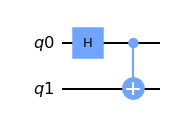

In [2]:
Qr1 = QuantumRegister(1)
Qr2 = QuantumRegister(1)

Qc = QuantumCircuit(Qr1,Qr2)

Qc.h(Qr1)
Qc.cx(Qr1, Qr2)

display(Qc.draw(output='mpl'))

sv = Statevector.from_label('00')
sv = sv.evolve(Qc)

print_bracket(sv)

### 2. lépés - 2. feladat: Alice műveletei 

A protokoll során összesen 3 qubitre van szükség, nevezzük ezeket az egyszerűség kedvéért $q_1$, $q_2$ és $q_3$-nak. Mint láttuk az első lépés során Alice és Bob is kap egy összefonódott qubit párt, ezek a $q_2$ és $q_3$ qubitek. Az első qubit pedig "tárolja" az állapotot ami Alice szeretne tovább küldeni. Így a 3 qubit kezdeti állapota

$$
\left(\alpha \vert0\rangle + \beta \vert1\rangle \right) \left(\frac{1}{\sqrt{2}} \vert00\rangle + \frac{1}{\sqrt{2}} \vert11\rangle\right)  = \frac{1}{\sqrt{2}}\left(\alpha\vert000\rangle + \alpha \vert011\rangle + \beta \vert100\rangle + \beta \vert111\rangle \right)
$$


A második lépés során Alice alkalmaz egy CNOT kaput $q_2$-re, amely az üzenetet tartalmazó $q_1$ qubit által van kontrollálva, majd alkalmaz egy Hadamard kaput a $q_1$-en.

***Adjátok meg a három qubit állapotát a CNOT, majd a Hadamard kapu alkalmazása után!***

-------------------------------

$
CX_{q_1,q_2}\frac{1}{\sqrt{2}}\left(\alpha\vert000\rangle + \alpha \vert011\rangle + \beta \vert100\rangle + \beta \vert111\rangle \right) =\, ?
$

$
H_{q_1}\left(CX_{q_1,q_2}\frac{1}{\sqrt{2}}\left(\alpha\vert000\rangle + \alpha \vert011\rangle + \beta \vert100\rangle + \beta \vert111\rangle \right)\right) =\, ?
$

ahol $CX_{q_1,q_2} = CX\otimes I$ és $H_{q_1} = H\otimes I \otimes I$

----------------------------------------


-------------------------------
$
\begin{array}{rl}
CX_{q_1,q_2}\frac{1}{\sqrt{2}}\left(\alpha\vert000\rangle + \alpha \vert011\rangle + \beta \vert100\rangle + \beta \vert111\rangle \right) & =  
\color{blue}{C}\color{red}{X} \otimes \color{green}{I} \frac{1}{\sqrt{2}}\left(\alpha\ket{\color{blue}{0}\color{red}{0}\color{green}{0}} + \alpha \ket{\color{blue}{0}\color{red}{1}\color{green}{1}} + \beta \ket{\color{blue}{1}\color{red}{0}\color{green}{0}} + \beta \ket{\color{blue}{1}\color{red}{1}\color{green}{1}} \right) \\& 
= \qquad \quad \frac{1}{\sqrt{2}}\left(\alpha\ket{\color{blue}{0}\color{red}{0}\color{green}{0}} + \alpha \ket{\color{blue}{0}\color{red}{1}\color{green}{1}} + \beta \ket{\color{blue}{1}\color{red}{1}\color{green}{0}} + \beta \ket{\color{blue}{1}\color{red}{0}\color{green}{1}} \right)
\end{array}
$

<br>

$
\Rightarrow CX_{q_1,q_2}\frac{1}{\sqrt{2}}\left(\alpha\vert000\rangle + \alpha \vert011\rangle + \beta \vert100\rangle + \beta \vert111\rangle \right) = \frac{1}{\sqrt{2}}\left(\alpha\vert000\rangle + \alpha \vert011\rangle + \beta \vert110\rangle + \beta \vert101\rangle \right)
$

<br>

$
H_{q_1} \ket{000} = H \otimes I \otimes I \ket{000} \propto (\ket{0}+\ket{1})\ket{00}
$

$
H_{q_1} \ket{011} = H \otimes I \otimes I \ket{011} \propto (\ket{0}+\ket{1})\ket{11}
$

$
H_{q_1} \ket{110} = H \otimes I \otimes I \ket{110}  \propto (\ket{0}-\ket{1})\ket{10}
$

$
H_{q_1} \ket{101}= H \otimes I \otimes I \ket{101} \propto (\ket{0}-\ket{1})\ket{01}
$

<br>

$
\Rightarrow \dfrac{1}{2}\left( \alpha (\ket{0}+\ket{1})\ket{00} + \alpha(\ket{0}+\ket{1})\ket{11} + \beta(\ket{0}-\ket{1})\ket{10} + \beta(\ket{0}-\ket{1})\ket{01} \right)
$


$
 = \dfrac{1}{2}\left( \alpha\ket{000} +\alpha \ket{100} +\alpha \ket{011} +\alpha \ket{111} + \beta \ket{010} - \beta \ket{110} + \beta\ket{001} - \beta\ket{101}  \right)
$

----------------------------------------


$
\boxed{
=\dfrac{1}{2}\left(
\ket{00}(\alpha \ket{0}+\beta\ket{1}) + 
\ket{01}(\beta \ket{0}+\alpha\ket{1}) +
\ket{10}(\alpha \ket{0}-\beta\ket{1}) +
\ket{11}(\alpha\ket{1}-\beta \ket{0})
\right)}
$

### 3. lépés - 3. feladat: Mérés

A 3. lépésben Alice megméri mindkét qubitjét ($q_1$ és $q_2$), majd az eredményt elküldi Bobnak. Alice az összes lehetséges bázisállapotot ($\left\{00, 01, 10, 11 \right\}$) azonos valószinűséggel mérheti.

***Milyen állapotban lehet Bob qubitje a mérés eredményének függvényében?***

<table>
    <tr>
        <th>  Mért állapot </th>
        <th>  Mérési valószínűség </th>
        <th>  Bob qubitje ($q_3 \sqrt{2} $)</th>
    </tr>
    <tr>
        <td>$\ket{00}$</td>
        <td> 0.25 </td>
        <td> $ \alpha \ket{0} + \beta  \ket{1} $ </td>
    </tr>
    <tr>
        <td> $\ket{01}$ </td>
        <td> 0.25 </td>
        <td> $ \beta  \ket{0} + \alpha \ket{1} $ </td>
    </tr>
    <tr>
        <td> $\ket{10}$ </td>
        <td> 0.25 </td>
        <td> $ \alpha \ket{0} - \beta  \ket{1} $ </td>
    </tr>
    <tr>
        <td> $\ket{11}$ </td>
        <td> 0.25 </td>
        <td> $ \beta  \ket{1} - \alpha \ket{0} $ </td>
    </tr>
</table>

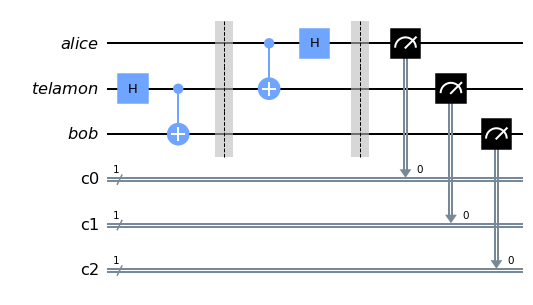

In [3]:
Qr1 = QuantumRegister(1, 'alice')
Qr2 = QuantumRegister(1, 'telamon')
Qr3 = QuantumRegister(1, 'bob')

Cr1 = ClassicalRegister(1)
Cr2 = ClassicalRegister(1)
Cr3 = ClassicalRegister(1)

Qc = QuantumCircuit(Qr1, Qr2, Qr3, Cr1, Cr2, Cr3)


#X#X#X#X#X#X#X#X#X#X#X#X Telamon #X#X#X#X#X#X#X#X#X#X#X#X

Qc.h(Qr2)
Qc.cx(Qr2, Qr3)

Qc.barrier(Qr1,Qr2,Qr3)

#X#X#X#X#X#X#X#X#X#X#X#X Alice  #X#X#X#X#X#X#X#X#X#X#X#X

Qc.cx(Qr1,Qr2)
Qc.h(Qr1)

Qc.barrier(Qr1, Qr2, Qr3)

sv = Statevector.from_label('000')
sv = sv.evolve(Qc)

print_bracket(sv)

#X#X#X#X#X#X#X#X#X#X#X Measurement  #X#X#X#X#X#X#X#X#X#X#X

Qc.measure(Qr1, Cr1)
Qc.measure(Qr2, Cr2)
Qc.measure(Qr3, Cr3)

display(Qc.draw(output='mpl'))



<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


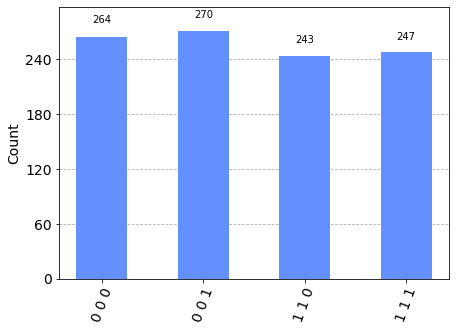

In [4]:
aer_sim = Aer.get_backend('aer_simulator')

qobj = assemble(Qc)
result = aer_sim.run(qobj).result()
counts = result.get_counts(Qc)
plot_histogram(counts)

### 4. lépés - 4. feladat: Dekódolás <a id='Bob'></a>

Az első 3 lépés után Bob rendelkezik a $q_3$ qubittel és klasszikus kommunikáció révén megkapta Alice méréseinek eredményeit, ekkor a protokoll utolsó lépésében a megfelelő kapukat alkalmazva a qubitjén előállíthatja az eredeti $\ket{\psi}$ állapotot.

***Minden lehetséges mérési eredmény esetén határozzátok meg a műveleteket, amelyekkel Bob elő tudja állítani a keresett állapotot!***

----------------------
00 $\rightarrow$ $I$

01 $\rightarrow$ $X$

10 $\rightarrow$ $Z$

11 $\rightarrow$ $ZX$

---------------------

<table>
    <tr>
        <th>Alice üzenete</th>
         <th>Kvantumállapot($\cdot 1/ \sqrt{2}$)</th>
        <th>Alkalmazott kapuk</th>
    </tr>
    <tr>
        <td>00</td>
        <td>$\alpha|0\rangle + \beta|1\rangle$</td>
        <td> I </td>
    </tr>
    <tr>
        <td>01</td>
        <td>$\beta|0\rangle + \alpha|1\rangle$</td>
        <td> X </td>
    </tr>
    <tr>
        <td>10</td>
        <td>$\alpha|0\rangle - \beta|1\rangle$</td>
        <td> Z </td>
    </tr>
    <tr>
        <td>11</td>
        <td>$\alpha|1\rangle - \beta |0\rangle$</td>
        <td> ZX </td>
    </tr>
</table>

## 3. Kvantumos teleportáció szimulálása - 5. feladat 

Egy, a fenti négy lépést megvalósító protokoll képes "teleportálni" egy kvatum állapotot egy qubitről a másikra csak lokális műveleteket és klasszikus komunikációt használva. Ahogyan láttuk az utolsó qubiten olyan műveleteket kellett alkalmaznunk amelyek függtek a másik két qubit mért állapotától.

Most, hogy végimentünk a protokoll lépésein itt az ideje hogy összeállítsuk az azt megvlósító logiakai áramkört.

***Hozzatok létre a qiskit segítségevel egy kvantum áramkört, amely megvalósítja a fenti protokollt!***
- az áramkör tartalmazzon 3 kvantum regisztert és 2 klasszikus regisztert
- alkalmazzatok az első  qubit-en forgatásokat, így kialakítva egy tetszőleges kezdeti állapotot (ezt az állapotot küldjük el)
- a protokollnak tartalmaznia kell két mérést
- és két kvantum kaput, amelyek alkalmazása a mérés eredményétől függ

***Az áramkör megalkotása után szimuláljuk annak működését az Aer szimulátor segítségével!***
- a szimulátor segítségével ellenőrizzük le az áramkör működését a qubitek protokoll alakalmazása utáni állapotának ellenőrzése által

<details>
    <summary>További segítség a feladat megoldásához.</summary>
    
<br>
<li>a megoldáshoz javasolt modulok:</li>

``` python
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister # áramkör létrehozása
from qiskit import IBMQ, Aer, transpile, assemble #áramkör szimulálása és futtatása
from qiskit.visualization import plot_histogram, plot_bloch_multivector # ábrázolás
```

<br>

<li> 3 kvantum és 2 klasszikus regiszterrel rendelkező áramkör létrehozása:</li>
    
``` python
qr = QuantumRegister(3) #kvantum regiszterek létrehozása
cr1 = ClassicalRegister(1) #klasszikus regiszter létrehozása
cr2 = ClassicalRegister(1) #klasszikus regiszter létrehozása
qc = QuantumCircuit(qr,cr1,cr2) #kvantum áramkör létrehozása
```      

<br>

<li>különböző kvantum logikai kapuk és mérések hozzáadása az áramkörhöz:</li>
    
``` python
qc.h(0) # Hadamard kapu az 1. qubiten (a kiválasztott qubit többféleképpen is megadható minden egyqubites kapu estén, nincs közöttük érdemi különbség)
#vagy
qc.h(qr[0]) 
#vagy
q0 = qr[0]
qc.h(q0)

qc.x(0) # X kapu a 1. qubiten 

qc.z(0) # Z kapu a 1. qubiten

qc.u3(theta, phi, lam,, 0) # 3 szögparaméteres (theta, phi, lam) általános forgatás alkalmazása a 1. qubiten

qc.cx(0,1) # CNOT (CX) kapu az 1. qubiten a 2. qubit által kontrollálva

qc.measure(0,cr1) # az 1. qubit mérése, az eredményt a cr1 klasszikus regiszter fogja tárolni

# a szimulált áramkör estén alkalmazhatunk feltételeket
qc.x(0).c_if(cr1, 1) # X kapu alkalmazása az 1. qubiten ha a cr1 klasszikus regiszter értéke "1"
    
```
    
<br>

<li> az áramkör ábrázolása:</li>
    
``` python
qc.draw(output='mpl') #az áramkör ábrázolása (matplotlib stílusban)
qc.draw() #az áramkör ábrázolása (text stílusban)
```    
<br>

<li> az áramkör szimulációja</li>

    
``` python
sim = Aer.get_backend('aer_simulator') # kiválasztjuk, hogy az Aer szimulátort szeretnénk használni és, hogy az állapotvektorokat akarjuk megkapni eredményül
qc.save_statevector()
out_vector = sim.run(qc).result().get_statevector() #futtatjuk az áramkört és lekérdezzük az eredményt leíró állapotvektorokat
plot_bloch_multivector(out_vector) #ábrázoljuk a kezdeti és végállapotokat a Bloch gömbön
```   

<br>
- ha hozzáadunk az áramkörhöz még egy a qr[2]-ön végrehajtott mérést akkor a legvégén az állapotvektor lekérdezése helyett vizsgálhatjuk a mérés eredményét is
- ehhez hozzá kell adnunk még egy klasszikus regisztert, amely a mérés eredményét fogja tárolni

```python
t_qc = transpile(qc, sim) #egy kísérlet létrehozása az általunk létrehozott áramkörből, melyet a kiválasztott backend-en végrehajtunk
counts = sim.run(t_qc).result().get_counts() #a kísérlet végrehajtása és a mérési eredmények lekérdezése
# a counts tartalmazza mindhárom qubit mért értékeit a kísérlet végén
qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(3)] #a mérések eredménye a különböző qubitekre vonatkoztatva
plot_histogram(counts) #az eredmények ábrázolása hisztogrammal
plot_histogram(qubit_counts)
```
    
</details>

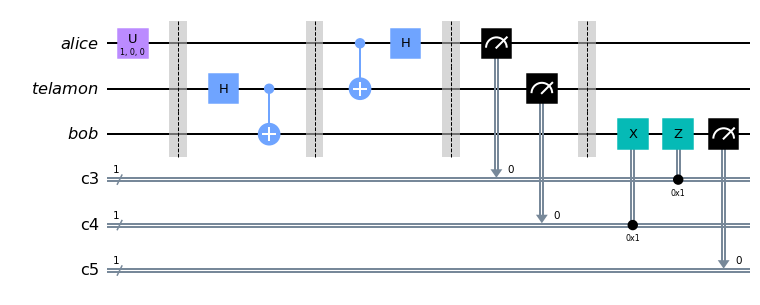

In [5]:
Qr1 = QuantumRegister(1, 'alice')
Qr2 = QuantumRegister(1, 'telamon')
Qr3 = QuantumRegister(1, 'bob')

Cr1 = ClassicalRegister(1)
Cr2 = ClassicalRegister(1)
Cr3 = ClassicalRegister(1)

Qc = QuantumCircuit(Qr1, Qr2, Qr3, Cr1, Cr2, Cr3)

#X#X#X#X#X#X#X#X#X#X#X#X kezdeti állapot #X#X#X#X#X#X#X#X
theta = 1
Qc.u(theta,0,0,Qr1)



Qc.barrier(Qr1,Qr2,Qr3)
#X#X#X#X#X#X#X#X#X#X#X#X Telamon #X#X#X#X#X#X#X#X#X#X#X#X

Qc.h(Qr2)
Qc.cx(Qr2, Qr3)

Qc.barrier(Qr1,Qr2,Qr3)

#X#X#X#X#X#X#X#X#X#X#X#X Alice  #X#X#X#X#X#X#X#X#X#X#X#X

Qc.cx(Qr1,Qr2)
Qc.h(Qr1)

Qc.barrier(Qr1, Qr2, Qr3)

#X#X#X#X#X#X#X#X#X#X#X 1. Mérés  #X#X#X#X#X#X#X#X#X#X
Qc.measure(Qr1, Cr1)
Qc.measure(Qr2, Cr2)

Qc.barrier(Qr1,Qr2,Qr3)

#X#X#X#X#X#X#X#X#X#X#X#X Bob  #X#X#X#X#X#X#X#X#X#X#X#X

Qc.x(Qr3).c_if(Cr2,1)
Qc.z(Qr3).c_if(Cr1,1)

#X#X#X#X#X#X#X#X#X#X#X 2. Mérés  #X#X#X#X#X#X#X#X#X#X

Qc.measure(Qr3, Cr3)

display(Qc.draw(output='mpl'))



In [6]:
print('kezdeti állapot:')
qc = QuantumCircuit(1)
qc.u(theta,0,0,0)
sv = Statevector.from_label('0')
sv = sv.evolve(qc)

print_bracket(sv)

print('P_0=',np.cos(theta/2)**2)
print('P_1=',np.sin(theta/2)**2)

kezdeti állapot:


P_0= 0.7701511529340699
P_1= 0.22984884706593015


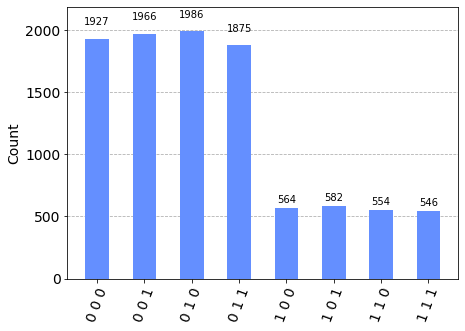

In [7]:
aer_sim = Aer.get_backend('aer_simulator')

qobj = assemble(Qc)
result = aer_sim.run(qobj, shots=10000).result()
counts = result.get_counts(Qc)
plot_histogram(counts)

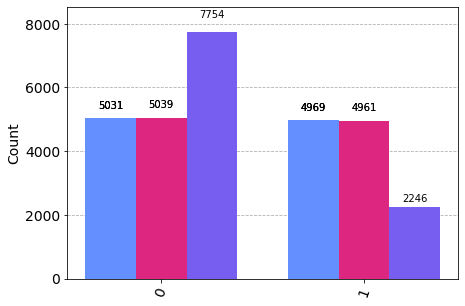

1. qubit


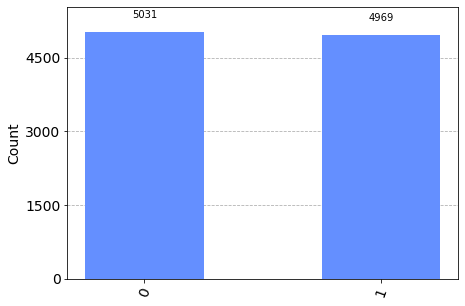

2. qubit


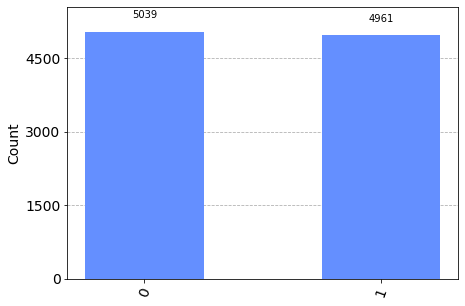

3. qubit


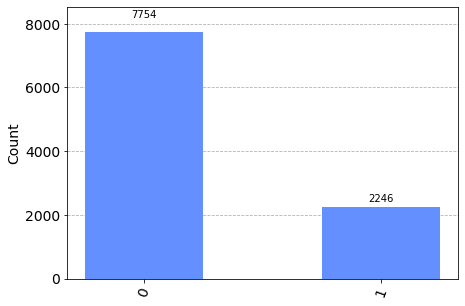

In [8]:
qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(3)]

display(plot_histogram(qubit_counts))
for i in range(len(qubit_counts)):
    print (str(i+1)+'. qubit')
    display(plot_histogram(qubit_counts[i]))

In [9]:
print('Kezdeti:')
print('P_0=',np.cos(theta/2)**2)
print('P_1=',np.sin(theta/2)**2)

print('Végső:')
print('P_0=',qubit_counts[2]['0'] / (qubit_counts[2]['0'] + qubit_counts[2]['1']))
print('P_1=',qubit_counts[2]['1'] / (qubit_counts[2]['0'] + qubit_counts[2]['1']))

Kezdeti:
P_0= 0.7701511529340699
P_1= 0.22984884706593015
Végső:
P_0= 0.7754
P_1= 0.2246


<a href="https://quantum-computing.ibm.com/composer/docs/iqx/operations_glossary"> Kvantum logikai kapuk IBM </a>  
<a href="https://qiskit.org/textbook/ch-states/single-qubit-gates.html"> Kvantum logikai kapuk  Qiskit</a>  

$
\cos\left(\frac{\theta}{2}\right)\ket{0} + e^{i\phi}\sin\left(\frac{\theta}{2}\right)\ket{1}
$

$
\phi=0 \Rightarrow \cos\left(\frac{\theta}{2}\right)\ket{0} + \sin\left(\frac{\theta}{2}\right)\ket{1}
$

$
\Downarrow \text{valószínűségek}
$

$
\cos\left(\frac{\theta}{2}\right)^2 \text{ és } \sin\left(\frac{\theta}{2}\right)^2
$

## 4. Kvantumos teleportáció valódi kvantumszámítógépen  - 6. feladat <a id='real'></a>

***Ha szükséges alakítsátok át az áramkört, hogy futtatni lehessen az IBM valamelyik kvantumszámítógépén!*** 

***Hajtsátok végre a protokollt az egyik elérhető kvantumszámítogépen és értelmezzétek az eredményt!***


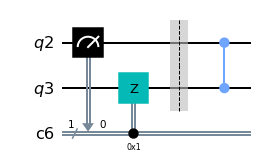

In [10]:
Qr1 = QuantumRegister(1)
Qr2 = QuantumRegister(1)
Cr = ClassicalRegister(1)

Qc = QuantumCircuit(Qr1, Qr2, Cr)
Qc.measure(Qr1,Cr)
Qc.z(Qr2).c_if(Cr,1)

Qc.barrier(Qr1,Qr2)

Qc.cz(Qr1, Qr2)

Qc.draw(output='mpl')

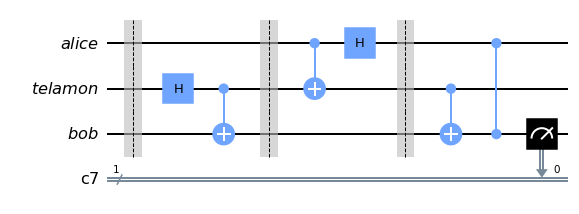

In [11]:
Qr1 = QuantumRegister(1, 'alice')
Qr2 = QuantumRegister(1, 'telamon')
Qr3 = QuantumRegister(1, 'bob')

Cr = ClassicalRegister(1)

Qc = QuantumCircuit(Qr1, Qr2, Qr3, Cr)

#X#X#X#X#X#X#X#X#X#X#X#X kezdeti állapot #X#X#X#X#X#X#X#X
theta = 1
#Qc.u3(theta,0,0,Qr1)
#Qc.x(Qr1)
Qc.barrier(Qr1,Qr2,Qr3)
#X#X#X#X#X#X#X#X#X#X#X#X Telamon #X#X#X#X#X#X#X#X#X#X#X#X

Qc.h(Qr2)
Qc.cx(Qr2, Qr3)

Qc.barrier(Qr1,Qr2,Qr3)

#X#X#X#X#X#X#X#X#X#X#X#X Alice  #X#X#X#X#X#X#X#X#X#X#X#X

Qc.cx(Qr1,Qr2)
Qc.h(Qr1)

Qc.barrier(Qr1, Qr2, Qr3)


#X#X#X#X#X#X#X#X#X#X#X#X Bob  #X#X#X#X#X#X#X#X#X#X#X#X

Qc.cx(Qr2, Qr3)  # Qc.x(Qr3).c_if(Cr2,1)
Qc.cz(Qr1, Qr3)  # Qc.z(Qr3).c_if(Cr1,1)
Qc.barrier

#X#X#X#X#X#X#X#X#X#X#X  Mérés  #X#X#X#X#X#X#X#X#X#X

Qc.measure(Qr3, Cr)

display(Qc.draw(output='mpl'))


In [12]:
from qiskit import IBMQ  
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor 
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')


<a href="https://quantum-computing.ibm.com/jobs">IBM Quantum -- Jobs </a>  

ibmq_manila
Job Status: job has successfully run


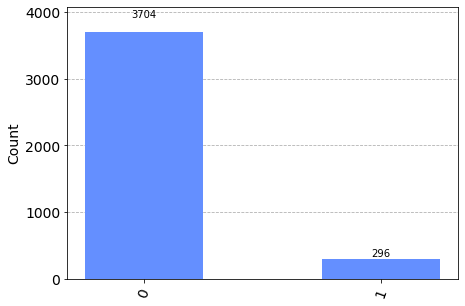

In [13]:
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and not x.configuration().simulator and x.status().operational==True))

print(backend)

t_qc = transpile(Qc, backend,optimization_level=0) 
job = backend.run(t_qc) 
job_monitor(job) 

exp_result = job.result() 
exp_counts = exp_result.get_counts(Qc)
plot_histogram(exp_counts)

In [14]:
def qc(theta):
    Qr1 = QuantumRegister(1, 'alice')
    Qr2 = QuantumRegister(1, 'telamon')
    Qr3 = QuantumRegister(1, 'bob')

    Cr = ClassicalRegister(3)

    Qc = QuantumCircuit(Qr1, Qr2, Qr3, Cr)

    #X#X#X#X#X#X#X#X#X#X#X#X kezdeti állapot #X#X#X#X#X#X#X#X
    Qc.u(theta,0,0,Qr1)
    Qc.barrier(Qr1,Qr2,Qr3)
    #X#X#X#X#X#X#X#X#X#X#X#X Telamon #X#X#X#X#X#X#X#X#X#X#X#X

    Qc.h(Qr2)
    Qc.cx(Qr2, Qr3)

    Qc.barrier(Qr1,Qr2,Qr3)

    #X#X#X#X#X#X#X#X#X#X#X#X Alice  #X#X#X#X#X#X#X#X#X#X#X#X

    Qc.cx(Qr1,Qr2)
    Qc.h(Qr1)

    Qc.barrier(Qr1, Qr2, Qr3)


    #X#X#X#X#X#X#X#X#X#X#X#X Bob  #X#X#X#X#X#X#X#X#X#X#X#X

    Qc.cx(Qr2, Qr3)  # Qc.x(Qr3).c_if(Cr2,1)
    Qc.cz(Qr1, Qr3)  # Qc.z(Qr3).c_if(Cr1,1)
    Qc.barrier

    #X#X#X#X#X#X#X#X#X#X#X  Mérés  #X#X#X#X#X#X#X#X#X#X

    Qc.measure(Qr3, Cr)

    display(Qc.draw(output='mpl'))

    print('P_0=',np.cos(theta/2)**2)
    print('P_1=',np.sin(theta/2)**2)
    return Qc

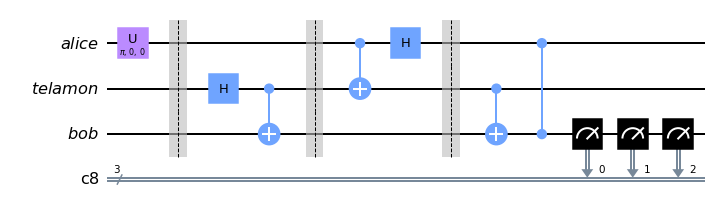

P_0= 3.749399456654644e-33
P_1= 1.0


In [15]:
Qc = qc(np.pi)

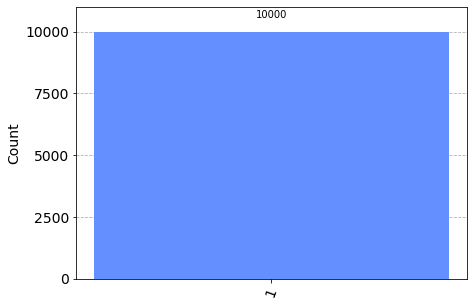

In [16]:
aer_sim = Aer.get_backend('aer_simulator')

qobj = assemble(Qc)
result = aer_sim.run(qobj, shots=10000).result()
counts = result.get_counts(Qc)
qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(3)]


display(plot_histogram(qubit_counts[-1]))



ibmq_manila
Job Status: job has successfully run


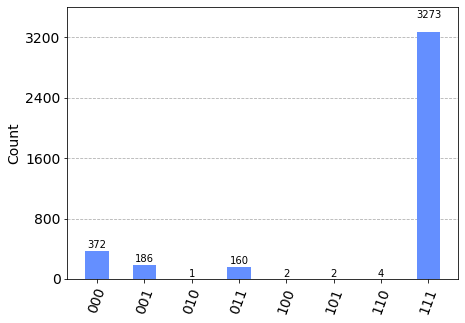

In [17]:
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and not x.configuration().simulator and x.status().operational==True))

print(backend)

t_qc = transpile(Qc, backend,optimization_level=0) 
job = backend.run(t_qc) 
job_monitor(job) 

exp_result = job.result() 
exp_counts = exp_result.get_counts(Qc)
plot_histogram(exp_counts)

In [18]:
qubit_counts = [marginal_counts(exp_counts, [qubit]) for qubit in range(3)]

print('P_0=',qubit_counts[2]['0'] / (qubit_counts[2]['0'] + qubit_counts[2]['1']))
print('P_1=',qubit_counts[2]['1'] / (qubit_counts[2]['0'] + qubit_counts[2]['1']))

P_0= 0.17975
P_1= 0.82025


In [19]:
#pi/2

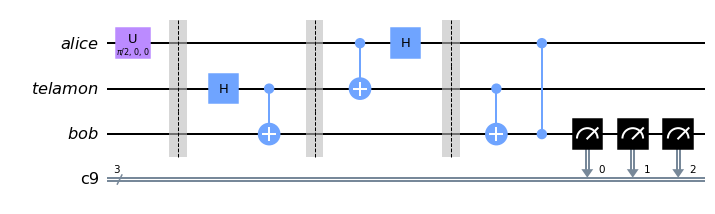

P_0= 0.5000000000000001
P_1= 0.4999999999999999


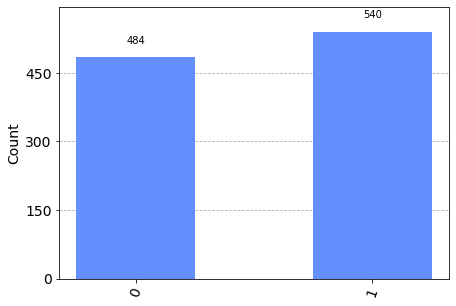

In [20]:
Qc = qc(np.pi/2)

aer_sim = Aer.get_backend('aer_simulator')

qobj = assemble(Qc)
result = aer_sim.run(qobj).result()
counts = result.get_counts(Qc)

qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(3)]


display(plot_histogram(qubit_counts[2]))


In [21]:
print('P_0=',qubit_counts[2]['0'] / (qubit_counts[2]['0'] + qubit_counts[2]['1']))
print('P_1=',qubit_counts[2]['1'] / (qubit_counts[2]['0'] + qubit_counts[2]['1']))

P_0= 0.47265625
P_1= 0.52734375


ibmq_manila
Job Status: job has successfully run


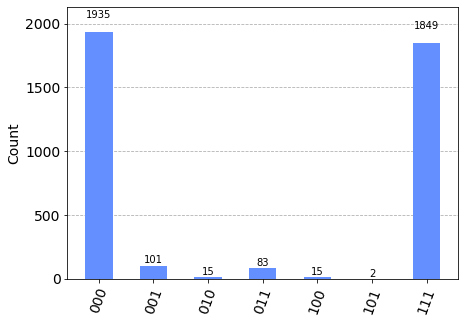

In [22]:
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and not x.configuration().simulator and x.status().operational==True))

print(backend)

t_qc = transpile(Qc, backend,optimization_level=0) 
job = backend.run(t_qc) 
job_monitor(job) 

exp_result = job.result() 
exp_counts = exp_result.get_counts(Qc)
plot_histogram(exp_counts)

In [23]:
qubit_counts = [marginal_counts(exp_counts, [qubit]) for qubit in range(3)]

print('P_0=',qubit_counts[2]['0'] / (qubit_counts[2]['0'] + qubit_counts[2]['1']))
print('P_1=',qubit_counts[2]['1'] / (qubit_counts[2]['0'] + qubit_counts[2]['1']))

P_0= 0.5335
P_1= 0.4665
